In [85]:
import pandas as pd
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import train_test_split
import tensorflow as tf
import requests 
from bs4 import BeautifulSoup
import json
from IPython.display import display, Image
import urllib.request

from PIL.ExifTags import TAGS
#import PIL.ExifTags #import TAGS
import PIL.Image

In [80]:
def extract_image_url(pd_series):
    '''
    Extracts image URLs from the pictures column in the RescuePets database.
    INPUT: Pandas Series where each item is a list of dictionaries of dictionaries??
    OUTPUT: Pandas Dataframe with 3 columns: 'url','size','resolution'
    '''
    large_image_urls = []
    small_image_urls = []
    full_size_image_urls = []
    
    for lst in pd_series:
        for dct in lst:
            large_image_urls.append(dct['largeUrl'])
            small_image_urls.append(dct['smallUrl'])
            full_size_image_urls.append(dct['fullsizeUrl'])
            
    return large_image_urls, small_image_urls, full_size_image_urls

In [81]:
def download_images(urls):
    '''
    Downloads all images from Rescue Pets S3 bucket 
    INPUT: List of Image urls (strings)
    OUTPUT: Images stored in data directory.
    '''
    for image_url in urls[0:25]:
        image_name = image_url.split('/')[-1]
        r = requests.get(image_url, allow_redirects = True)
        open('data/'+image_name, 'wb').write(r.content)

In [86]:
def rotate_image(file):
    '''
    Rotates images uploaded by user's smartphone via exif data.
    Images need to be rotated to proper orientation prior to preprocessing step.
    '''
    image=Image.open(file)
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation]=='Orientation':
                break
            exif=dict(image._getexif().items())
    
        if exif[orientation] == 3:
            print('ROTATING 180')
            image=image.rotate(180, expand=True)
        elif exif[orientation] == 6:
            print('ROTATING 270')
            image=image.rotate(270, expand=True)
        elif exif[orientation] == 8:
            print('ROTATING 90')
            image=image.rotate(90, expand=True)
        image.save(filepath)
        image.close()
    except (AttributeError, KeyError, IndexError):
    # cases: image don't have getexif   
        pass
    return(image)

In [4]:
df = pd.read_json('data/h9DH7711_newpets_1.json', lines=True)

In [5]:
df.head(5)

,activityLevel,adoptionFee,affectionate,age,altered,animalID,animalLocation,apartment,birthdate,breed,...,summary,swims,tailType,timid,trackerImageUrl,uptodate,videoUrls,videos,vocal,yardRequired
0,Moderately Active,,,Adult,,13398118,85009,Yes,8/9/2013,Terrier / Mixed (medium coat),...,,,,Yes,https://tracker.rescuegroups.org/pet?13398118&...,,[],[],Some,Yes
1,Moderately Active,,Yes,Adult,Yes,13398123,85009,,8/9/2014,American Pit Bull Terrier / Mixed (short coat),...,,,Short,,https://tracker.rescuegroups.org/pet?13398123&...,,[{'youtubeVideoUrl': 'https://www.youtube.com/...,[],,
2,,,,Adult,,13398132,78227,,8/8/2013,German Shepherd Dog / Mixed (medium coat),...,,,,,https://tracker.rescuegroups.org/pet?13398132&...,,[],[],,
3,,,,Adult,,13398133,78227,,8/8/2015,Pit Bull Terrier / Mixed (medium coat),...,,,,,https://tracker.rescuegroups.org/pet?13398133&...,,[],[],,
4,,,,Adult,,13398134,78227,,,Chihuahua / Mixed (medium coat),...,,,,,https://tracker.rescuegroups.org/pet?13398134&...,,[],[],,


In [6]:
df.columns.values

array(['activityLevel', 'adoptionFee', 'affectionate', 'age', 'altered',
       'animalID', 'animalLocation', 'apartment', 'birthdate', 'breed',
       'cats', 'coatLength', 'color', 'contactCellPhone', 'contactEmail',
       'contactHomePhone', 'contactName', 'courtesy', 'cratetrained',
       'declawed', 'description', 'descriptionPlain', 'dogs', 'drools',
       'eagerToPlease', 'earType', 'energyLevel', 'escapes',
       'eventempered', 'exerciseNeeds', 'eyeColor', 'fence', 'fetches',
       'found', 'foundDate', 'foundZipcode', 'gentle', 'goodInCar',
       'goofy', 'groomingNeeds', 'hasAllergies', 'hearingImpaired',
       'housetrained', 'hypoallergenic', 'independent', 'intelligent',
       'kids', 'killDate', 'killReason', 'lap', 'lastUpdated',
       'leashtrained', 'mediaLastUpdated', 'messagePet', 'mixed', 'name',
       'needsFoster', 'newPeople', 'noCold', 'noFemaleDogs', 'noHeat',
       'noLargeDogs', 'noMaleDogs', 'noSmallDogs', 'oKForSeniors',
       'oKWithAdults', '

In [208]:
#Columns to drop?: 'petUrl','drools' 
#Columns to rename?: animalLocation to zipcode use GeoPy to get city and state? 
#Activity Level change to scale from 1 to 4?
#Age change to numeric scale from 1 to 4 for Baby, Young, Adult, Senior? '' = UNK?
#'apartment', 'cratetrained', 'declawed' change to numeric 0,1=yes
#'birthdate' to get exact age? lot of nulls
#'breed','color', 'descriptionPlain'...tokenize with NLP? Combine them?
#'eventempered',eagerToPlease','cats','dogs' good with cats or dogs?, change to numeric? 0,1,2=UNK
#'coatLength' Med, Short, Long, ''=UNK
#'contactEmail' & 'contactCellPhone'=='contactHomePhone' drop? only 1 seen in new Dog JSON...only drop after merging all JSONs!!
#'contactName' foster? drop?
#'exerciseNeeds' Low, Moderate, High, Not Required, ''=UNK...combine with activity level?
#'description' == 'trackerImageUrl'
#'eyeColor' various string descriptions lot of blanks.. merge to description?
#'fence'..Not Required, Any Type, 3ft or 6ft
#Need more info on following columns: 'altered','courtesy','lastUpdated','mediaLastUpdated','MessagePet'

#df[df['eyeColor']==''].count()
#df.activityLevel.isnull().count()
#df[df['earType']==''].count()
#type(df.breed[10])
#df.shape
#df.eagerToPlease.unique()
df.pictures[698]
#df.animalID[27]

[{'originalUrl': 'https://s3.amazonaws.com/filestore.rescuegroups.org/956/pictures/animals/13400/13400228/59460401_960x720.jpg',
  'largeUrl': 'https://s3.amazonaws.com/filestore.rescuegroups.org/956/pictures/animals/13400/13400228/59460401_500x375.jpg',
  'smallUrl': 'https://s3.amazonaws.com/filestore.rescuegroups.org/956/pictures/animals/13400/13400228/59460401_100x75.jpg',
  'fullsizeUrl': 'https://s3.amazonaws.com/filestore.rescuegroups.org/956/pictures/animals/13400/13400228/59460401_500x375.jpg',
  'thumbnailUrl': 'https://s3.amazonaws.com/filestore.rescuegroups.org/956/pictures/animals/13400/13400228/59460401_100x75.jpg',
  'mediaID': '59460401',
  'mediaOrder': '1',
  'lastUpdated': '1533840393',
  'original': {'fileSize': '113344',
   'resolutionX': '960',
   'resolutionY': '720',
   'url': 'https://s3.amazonaws.com/filestore.rescuegroups.org/956/pictures/animals/13400/13400228/59460401_960x720.jpg'},
  'large': {'fileSize': '39810',
   'resolutionX': '500',
   'resolutionY':

In [6]:
a,b,c = extract_image_url(df.pictures)

In [7]:
len(a)
#df.pictures dictionary of image links
#choose 500x373 resolution


#image = urllib.request.urlretrieve(b[120])
#image

2821

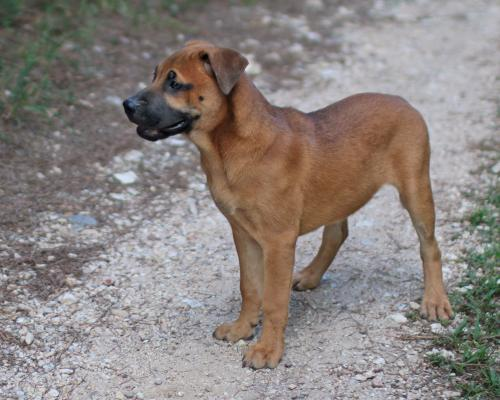

In [270]:
Image(image_name)

In [ ]:
df.videoUrls[1]
#https://www.youtube.com/watch?v=MTbyReR7Vhg

/Users/bil2ab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a297a4358>,
      dtype=object)

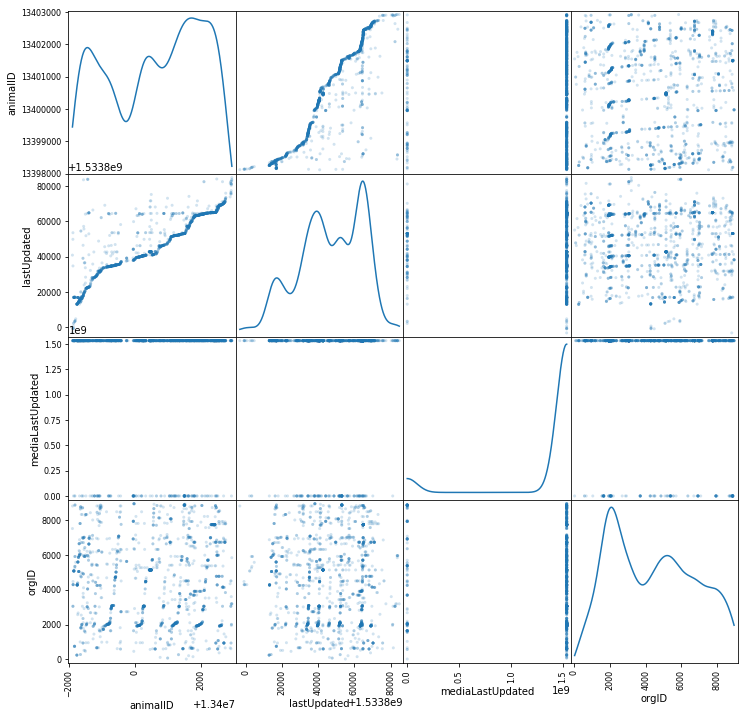

In [26]:
pd.scatter_matrix(df, alpha=0.2, diagonal='kde', figsize=(12,12))

In [ ]:
model = Sequential()
model.add(Dense(units=128, activation='relu', input_dim=))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=2, activation='linear', name='bottleneck'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=784, activation='hard_sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model = Sequential()
model.add(Dense(units=128, activation='relu', input_dim=28*28))
model.add(Dense(units=64, activation='relu'))


In [ ]:
import requests
import pymongo

mc = pymongo.MongoClient()
scraper_db = mc['scraper']
sites = scraper_db['sites']
sites.delete_many({})


def retrieve_site(url:str) -> bytes:
    for site in sites.find():
        if site['url'] == url:
            return site['data']

        
def scrape_site(url:str) -> bytes:
    data = retrieve_site(url)
    if data:
        return data
    response = requests.get(url)
    data = response.content
    sites.insert_one({'url': url,'data': data})
    return data

In [260]:
import time as t
import math
import numpy as np

def f(x):
    result = 0
    for num in range(1000000):
        result += (4**math.sin(np.exp(x)))**0.5
    return result

def time_function(f, x):
    start_time = t.time()
    result = f(x)
    end_time = t.time()
    return (end_time-start_time, result)

In [261]:
time_function(f,5)

(3.64001727104187, 620846.5288395594)

In [264]:
def find_change(denom, value):
    d = {}
    for num in sorted(denom, reverse=True):
        x = value//num
        d[num] = x
        value -= num*x
    return d

In [268]:
find_change([1, 5, 10, 20, 100], 925694**4)

{100: 7342936883357918940364, 20: 4, 10: 1, 5: 1, 1: 1}

In [38]:
import keras
import numpy as np
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline
 
#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet')
 
#Load the Inception_V3 model
#inception_model = inception_v3.InceptionV3(weights='imagenet')
 
#Load the ResNet50 model
#resnet_model = resnet50.ResNet50(weights='imagenet')
 
#Load the MobileNet model
#mobilenet_model = mobilenet.MobileNet(weights='imagenet')

PIL image size (224, 224)


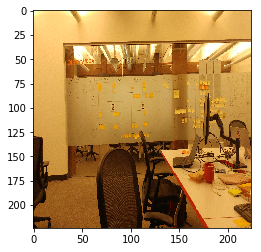

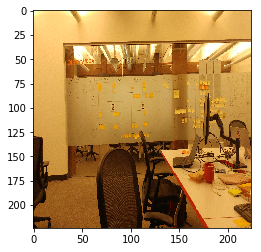

numpy array size (224, 224, 3)
image batch size (1, 224, 224, 3)


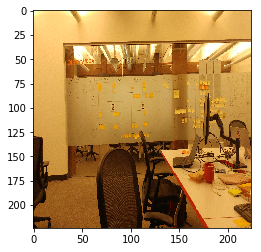

In [103]:
from PIL import Image

filename = 'data/room.jpg'

#im = Image.open(filename)
#im.rotate(-90).show()
#rotate_image(filename)

# Load image in PIL format
original = load_img(filename, target_size=(224, 224))
print('PIL image size', original.size)
plt.imshow(original)
plt.show()
 
# Convert PIL image to NumPy array
# IN PIL - image is in (width, height, channel)
# In Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)
plt.imshow(np.uint8(numpy_image))
plt.show()
print('numpy array size',numpy_image.shape)
 
# Convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# We want the input matrix to the network to be of the form (batchsize, height, width, channels)
# Thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)
plt.imshow(np.uint8(image_batch[0]))

In [104]:
from PIL.ExifTags import TAGS

im = PIL.Image.open(filename)
exifdict = im._getexif()
#print(exifdict)

if len(exifdict):
    for k in exifdict.keys():
        if k in TAGS.keys():
            print(TAGS[k], exifdict[k])
        else:
            print(k, exifdict[k])

GPSInfo {1: 'N', 2: ((47, 1), (30, 1), (319428, 10000)), 3: 'W', 4: ((122, 1), (16, 1), (446512, 10000)), 5: b'\x00', 6: (0, 1000), 7: ((22, 1), (32, 1), (52, 1)), 29: '2018:08:20'}
ResolutionUnit 2
ExifOffset 191
Make LG Electronics
Model VS987
DateTime 2018:08:20 15:32:55
YCbCrPositioning 1
Orientation 1
XResolution (72, 1)
YResolution (72, 1)
ExifVersion b'0220'
ColorSpace 1
ExposureMode 0
ExifImageHeight 2988
DateTimeDigitized 2018:08:20 15:32:55
SceneType b'\x01'
SceneCaptureType 0
DigitalZoomRatio (100, 100)
WhiteBalance 1
ExifImageWidth 5312
FocalLength (442, 100)
MeteringMode 2
DateTimeOriginal 2018:08:20 15:32:55
UserComment b'   FM0   FC111011111:zzzzzz0 a12a 0078044079c3f65883c014c0 bac f8206 4e 5832d1fc315  0  0  0  0 0 0 0 031531ba31a77d061 130b31b131a27d060 130131a831987d0 b 12f7318e31837d078 130b316c315e7d060 1310319831877d060 1315319b318b7d060 131a319e31867d060 131f31a5318c7d060 131a31a531837d060 14e514e514e514e514d4f4d4f4d4f4d4f48494849484948494445444544454445444644464

In [102]:
# prepare the image for the VGG model
processed_image = vgg16.preprocess_input(image_batch.copy())
#processed_image = inception_v3.preprocess_input(image_batch.copy())

# get the predicted probabilities for each class
predictions = vgg_model.predict(processed_image)
# print predictions
 
# convert the probabilities to class labels
# We will get top 5 predictions which is the default
label = decode_predictions(predictions)
print(label)

[[('n02087394', 'Rhodesian_ridgeback', 0.34898803), ('n02105162', 'malinois', 0.22982205), ('n02106662', 'German_shepherd', 0.1478375), ('n02108422', 'bull_mastiff', 0.048030473), ('n02115641', 'dingo', 0.03800784)]]


In [65]:
label[0][0]

('n04081281', 'restaurant', 0.18137836)